#FART Data Curation



In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 48.8 MB/s eta 0:00:0000:0100:01


In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import rdmolops
from rdkit.Chem import rdMolDescriptors

## Data curation

Now that we have the dataset available as a csv file, we can load it and start curating it, using the Pandas library. Load the csv into a Pandas DataFrame and display it.

In [ ]:
import pandas as pd

df = pd.read_csv('fart_uncurated.csv')

# Check and drop any unnamed index columns if they exist
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

df

,Canonicalized SMILES,Canonicalized Taste,Original Labels,Source
0,Oc1cc2c(cc1O)C1c3ccc(O)c(O)c3OCC1(O)C2,sweet,"Sweet, Sweetness",chemtastes_db
1,CC(C)=CCCC(C)(O)C1CC(O)C(C)=CC1=O,sweet,"Sweet, Sweetness",chemtastes_db
2,CC(=O)OC1C(=O)c2c(O)cc(O)cc2OC1c1ccc(O)c(O)c1,sweet,"Sweet, Sweetness",chemtastes_db
3,Oc1cc2c(cc1O)C1c3ccc(O)c(O)c3OCC1(O)C2,sweet,"Sweet, Sweetness",chemtastes_db
4,OC1C(O)C(O)C(O)C(O)C1O,sweet,"Sweet, Sweetness",chemtastes_db
...,...,...,...,...
33858,CC(=O)N(c1c(C)cccc1C)N1CCN(C(=O)OCc2ccccc2)CC1,sour,pKa between 2 and 7,IUPAC Dissocation Constants
33859,C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@@H]3CC[C@@H]4...,sour,pKa between 2 and 7,IUPAC Dissocation Constants
33860,C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C...,sour,pKa between 2 and 7,IUPAC Dissocation Constants
33861,O=C1c2ccccc2C(=O)C1c1ccc(C2C(=O)c3ccccc3C2=O)c...,sour,pKa between 2 and 7,IUPAC Dissocation Constants


In [18]:
# Create an empty list that will be filled after every data curation step to keep track of our dataset size
number_molecules = []
number_molecules.append(len(df))

In [19]:
# A function to create a column with RDKit mol objects
def smiles_to_mol(smiles):
    """Create mol object from SMILES else put None

    Args:
        smiles (str): SMILES representation of the molecule.

    Returns:
        mol: RDKit mol object or None if the SMILES is invalid or has more than one uncharged fragment
    """
    if not isinstance(smiles, str):
        return None

    try:
        # Convert the SMILES string to an RDKit molecule object
        mol = Chem.MolFromSmiles(smiles)

        return mol
    except:
        return None

In [20]:
# Add a column with RDKit Mol objects
df['mol'] = df['Canonicalized SMILES'].apply(smiles_to_mol)

# Filter out rows where 'mol' is None
df = df[df['mol'].notna()]

number_molecules.append(len(df))

[11:47:12] WARNING: not removing hydrogen atom without neighbors
[11:47:12] WARNING: not removing hydrogen atom without neighbors
[11:47:12] WARNING: not removing hydrogen atom without neighbors
[11:47:12] WARNING: not removing hydrogen atom without neighbors
[11:47:12] WARNING: not removing hydrogen atom without neighbors
[11:47:12] WARNING: not removing hydrogen atom without neighbors
[11:47:12] WARNING: not removing hydrogen atom without neighbors
[11:47:13] WARNING: not removing hydrogen atom without neighbors
[11:47:13] WARNING: not removing hydrogen atom without neighbors
[11:47:13] WARNING: not removing hydrogen atom without neighbors
[11:47:13] WARNING: not removing hydrogen atom without neighbors
[11:47:13] WARNING: not removing hydrogen atom without neighbors
[11:47:13] WARNING: not removing hydrogen atom without neighbors
[11:47:13] WARNING: not removing hydrogen atom without neighbors
[11:47:13] WARNING: not removing hydrogen atom without neighbors
[11:47:13] WARNING: not r

[11:47:15] WARNING: not removing hydrogen atom without neighbors
[11:47:15] WARNING: not removing hydrogen atom without neighbors
[11:47:15] WARNING: not removing hydrogen atom without neighbors
[11:47:15] WARNING: not removing hydrogen atom without neighbors
[11:47:15] WARNING: not removing hydrogen atom without neighbors
[11:47:15] WARNING: not removing hydrogen atom without neighbors
[11:47:15] WARNING: not removing hydrogen atom without neighbors
[11:47:15] WARNING: not removing hydrogen atom without neighbors
[11:47:15] WARNING: not removing hydrogen atom without neighbors
[11:47:15] WARNING: not removing hydrogen atom without neighbors
[11:47:15] WARNING: not removing hydrogen atom without neighbors
[11:47:16] WARNING: not removing hydrogen atom without neighbors
[11:47:16] WARNING: not removing hydrogen atom without neighbors
[11:47:16] WARNING: not removing hydrogen atom without neighbors
[11:47:16] WARNING: not removing hydrogen atom without neighbors
[11:47:16] WARNING: not r

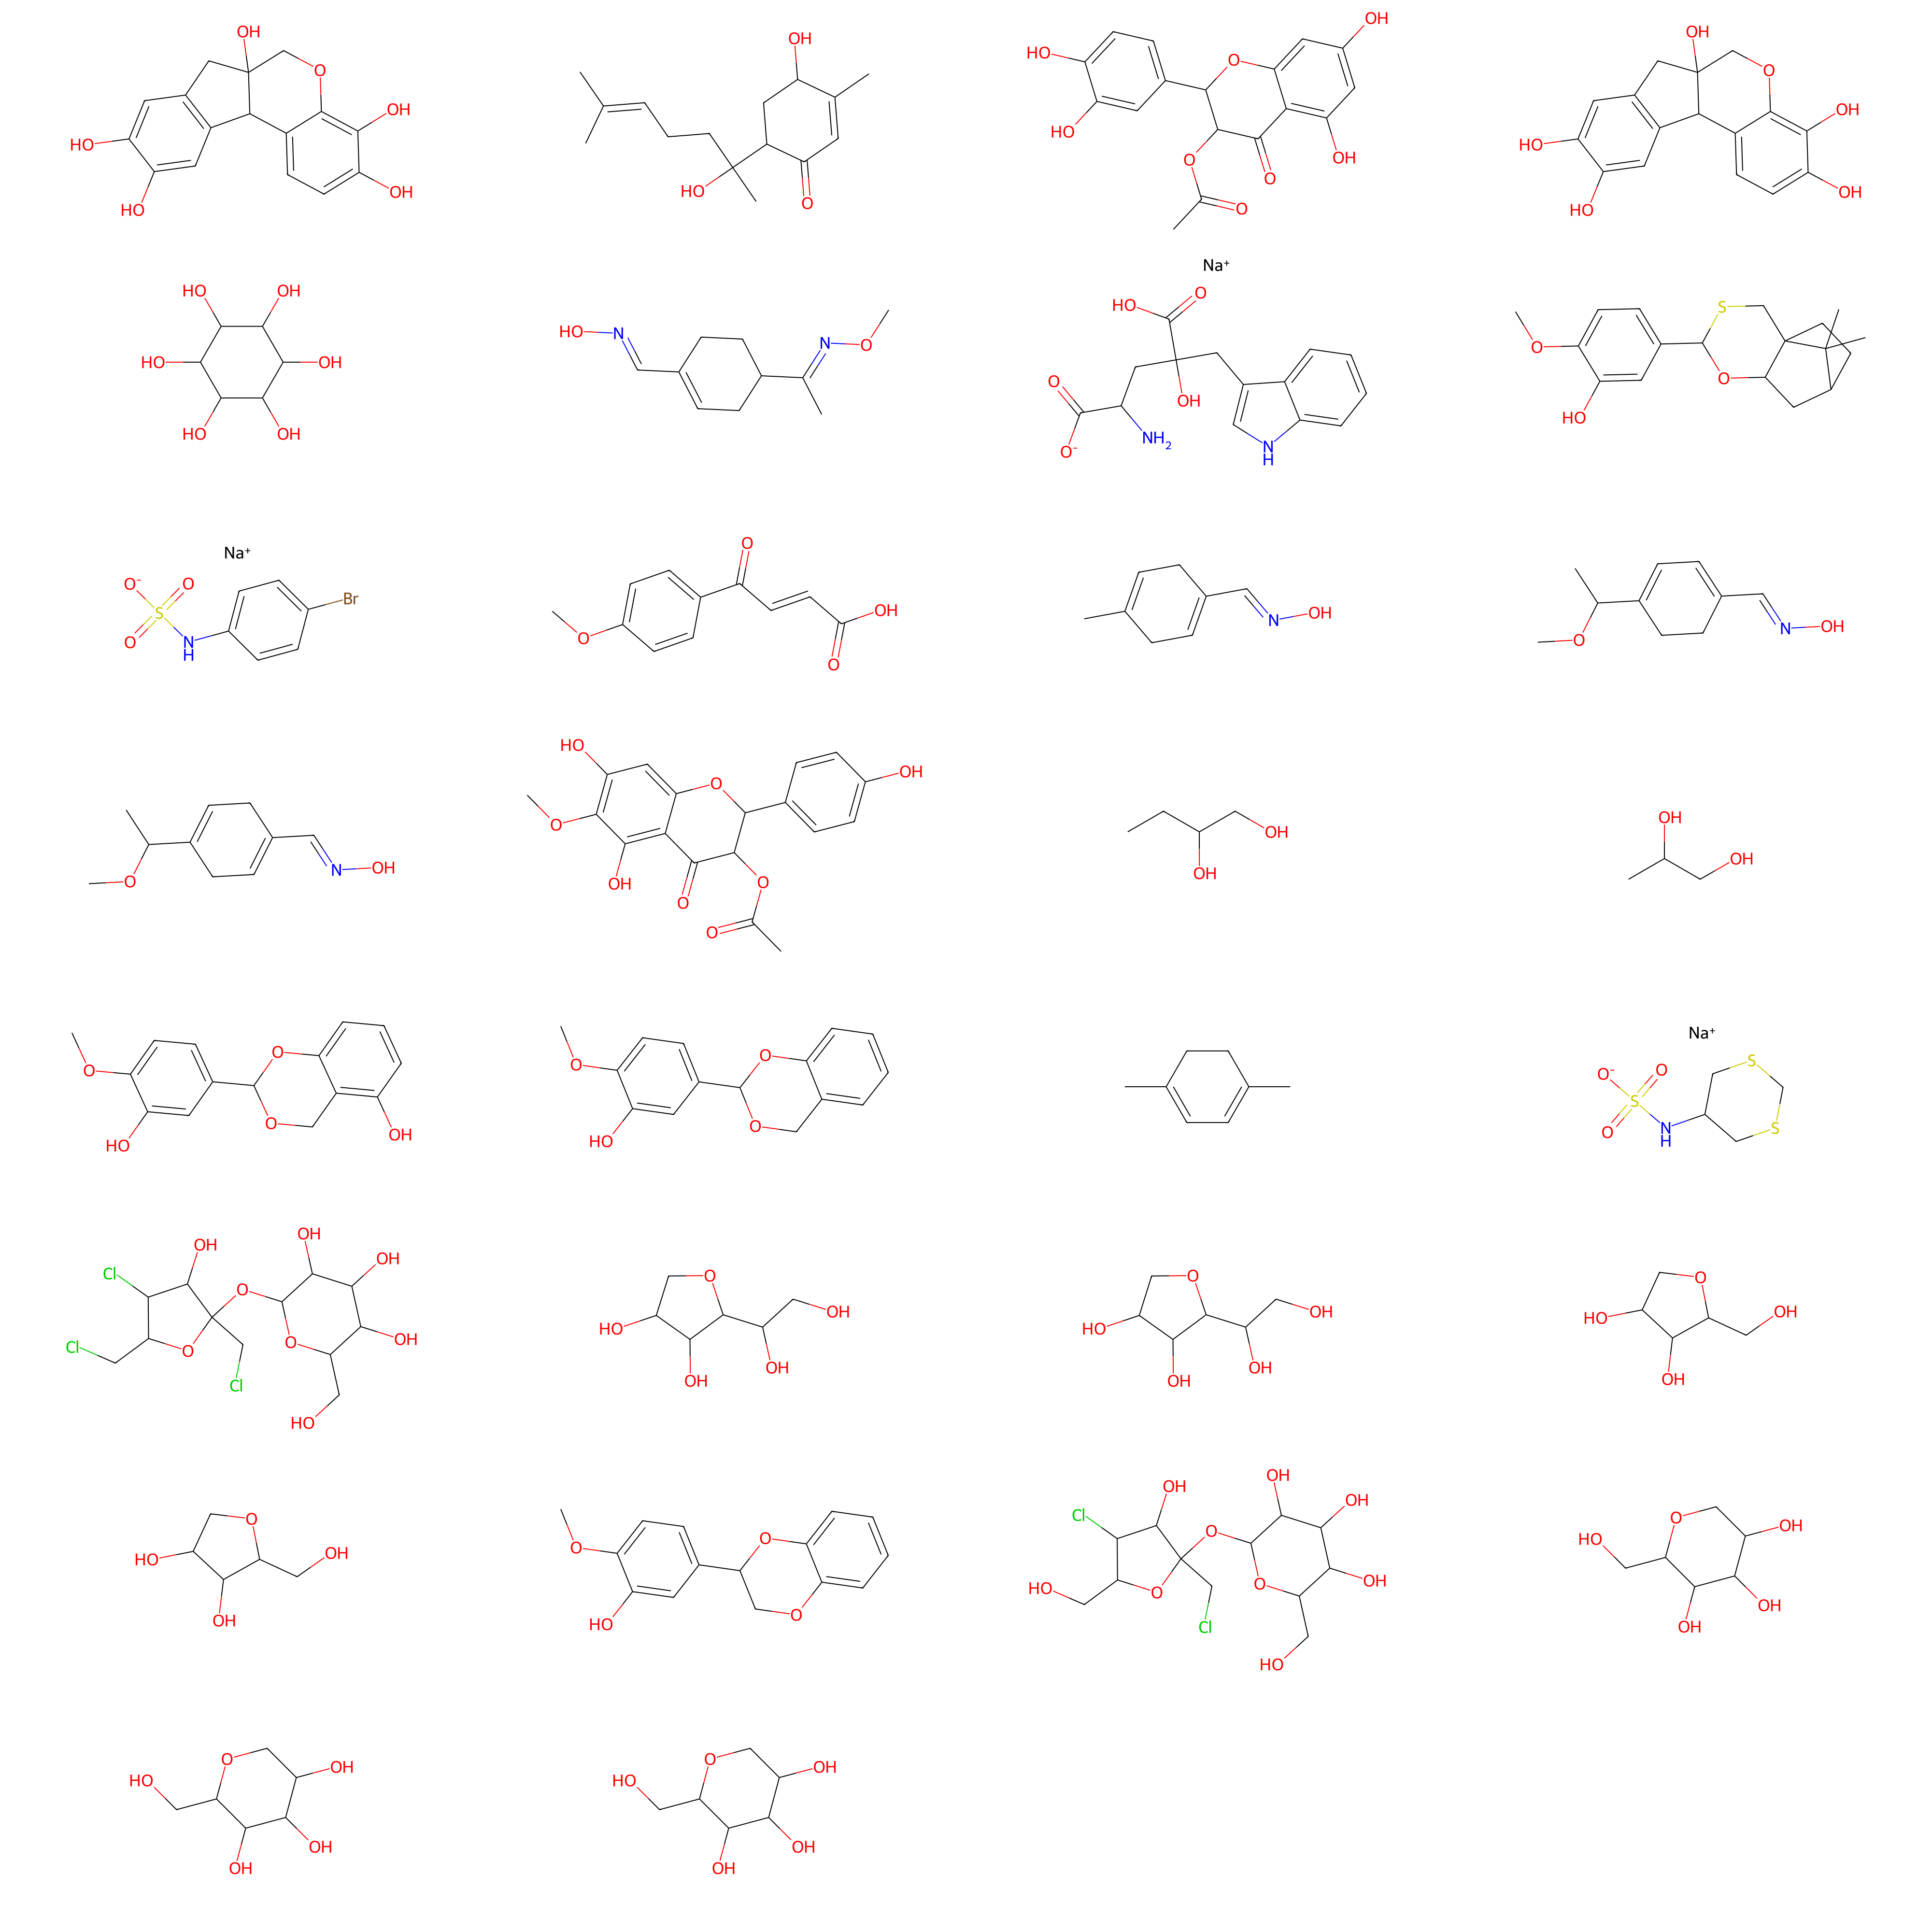

In [21]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='Canonicalized SMILES', molCol='mol')
PandasTools.FrameToGridImage(df, column='mol', legendsCol=None, molsPerRow=4, subImgSize=(1000, 500), maxMols=30)

We want to remove:

*   Species that consist of more than one fragment (e.g. solvents which are still in the SMILES)
*   Charged species, as they are missing a counter-ion


In [22]:

# A function that returns True if a SMILES contains one uncharged fragment and False otherwise
def mol_contains_multiple_uncharged_fragment(mol):
    """Check if the given SMILES string represents a molecule with more than one uncharged fragment.

    Args:
      mol: RDKit mol object of the molecule.

    Returns:
      bool: True if the molecule has exactly one uncharged fragment, False otherwise.
    """
    # Use GetMolFrags to find the disconnected fragments in the molecule
    fragment_mols = [Chem.MolFromSmiles(Chem.MolToSmiles(frag)) for frag in Chem.GetMolFrags(mol, asMols=True)]
    uncharged_count = sum(1 for frag in fragment_mols if rdmolops.GetFormalCharge(frag) == 0)

    # Check if the number of uncharged fragments is exactly 1
    return uncharged_count == 1

# Create a mask that is True if the SMILES contains one fragment and remove otherwise
mask = df['mol'].apply(mol_contains_multiple_uncharged_fragment)

PandasTools.FrameToGridImage(df[~mask], column='mol', legendsCol=None, molsPerRow=4, subImgSize=(1000, 500), maxMols=30)
df = df[mask]

number_molecules.append(len(df))

[11:47:19] WARNING: not removing hydrogen atom without neighbors
[11:47:19] WARNING: not removing hydrogen atom without neighbors
[11:47:19] WARNING: not removing hydrogen atom without neighbors
[11:47:19] WARNING: not removing hydrogen atom without neighbors
[11:47:19] WARNING: not removing hydrogen atom without neighbors
[11:47:19] WARNING: not removing hydrogen atom without neighbors
[11:47:19] WARNING: not removing hydrogen atom without neighbors
[11:47:20] WARNING: not removing hydrogen atom without neighbors
[11:47:20] WARNING: not removing hydrogen atom without neighbors
[11:47:20] WARNING: not removing hydrogen atom without neighbors
[11:47:21] WARNING: not removing hydrogen atom without neighbors
[11:47:21] WARNING: not removing hydrogen atom without neighbors
[11:47:21] WARNING: not removing hydrogen atom without neighbors
[11:47:21] WARNING: not removing hydrogen atom without neighbors
[11:47:21] WARNING: not removing hydrogen atom without neighbors
[11:47:21] WARNING: not r

In [23]:
# Create a mask that is True if molecules are uncharged and remove otherwise
mask = df['mol'].apply(rdmolops.GetFormalCharge) == 0

PandasTools.FrameToGridImage(df[~mask], column='mol', legendsCol=None, molsPerRow=4, subImgSize=(1000, 500), maxMols=30)
df = df[mask]

number_molecules.append(len(df))

## Standardization

In [24]:
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger

def standardise_smiles(smiles):
    '''
    Args:
        smiles (str): SMILES representation of the molecule.

      Returns:
        String: standardized version of the input SMILES
    '''
    return rdMolStandardize.StandardizeSmiles(smiles)

RDLogger.DisableLog('rdApp.info')

# Create a new column which contains the standardised smiles
df['Standardized SMILES'] = df['Canonicalized SMILES'].apply(standardise_smiles)

[11:47:37] WARNING: not removing hydrogen atom without neighbors
[11:47:41] WARNING: not removing hydrogen atom without neighbors
[11:47:46] WARNING: not removing hydrogen atom without neighbors
[11:47:46] WARNING: not removing hydrogen atom without neighbors
[11:47:47] WARNING: not removing hydrogen atom without neighbors


/Users/lsieben/Documents/ChemProp/.conda/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 30. Change the maxMols value to display more.
  warnings.warn(


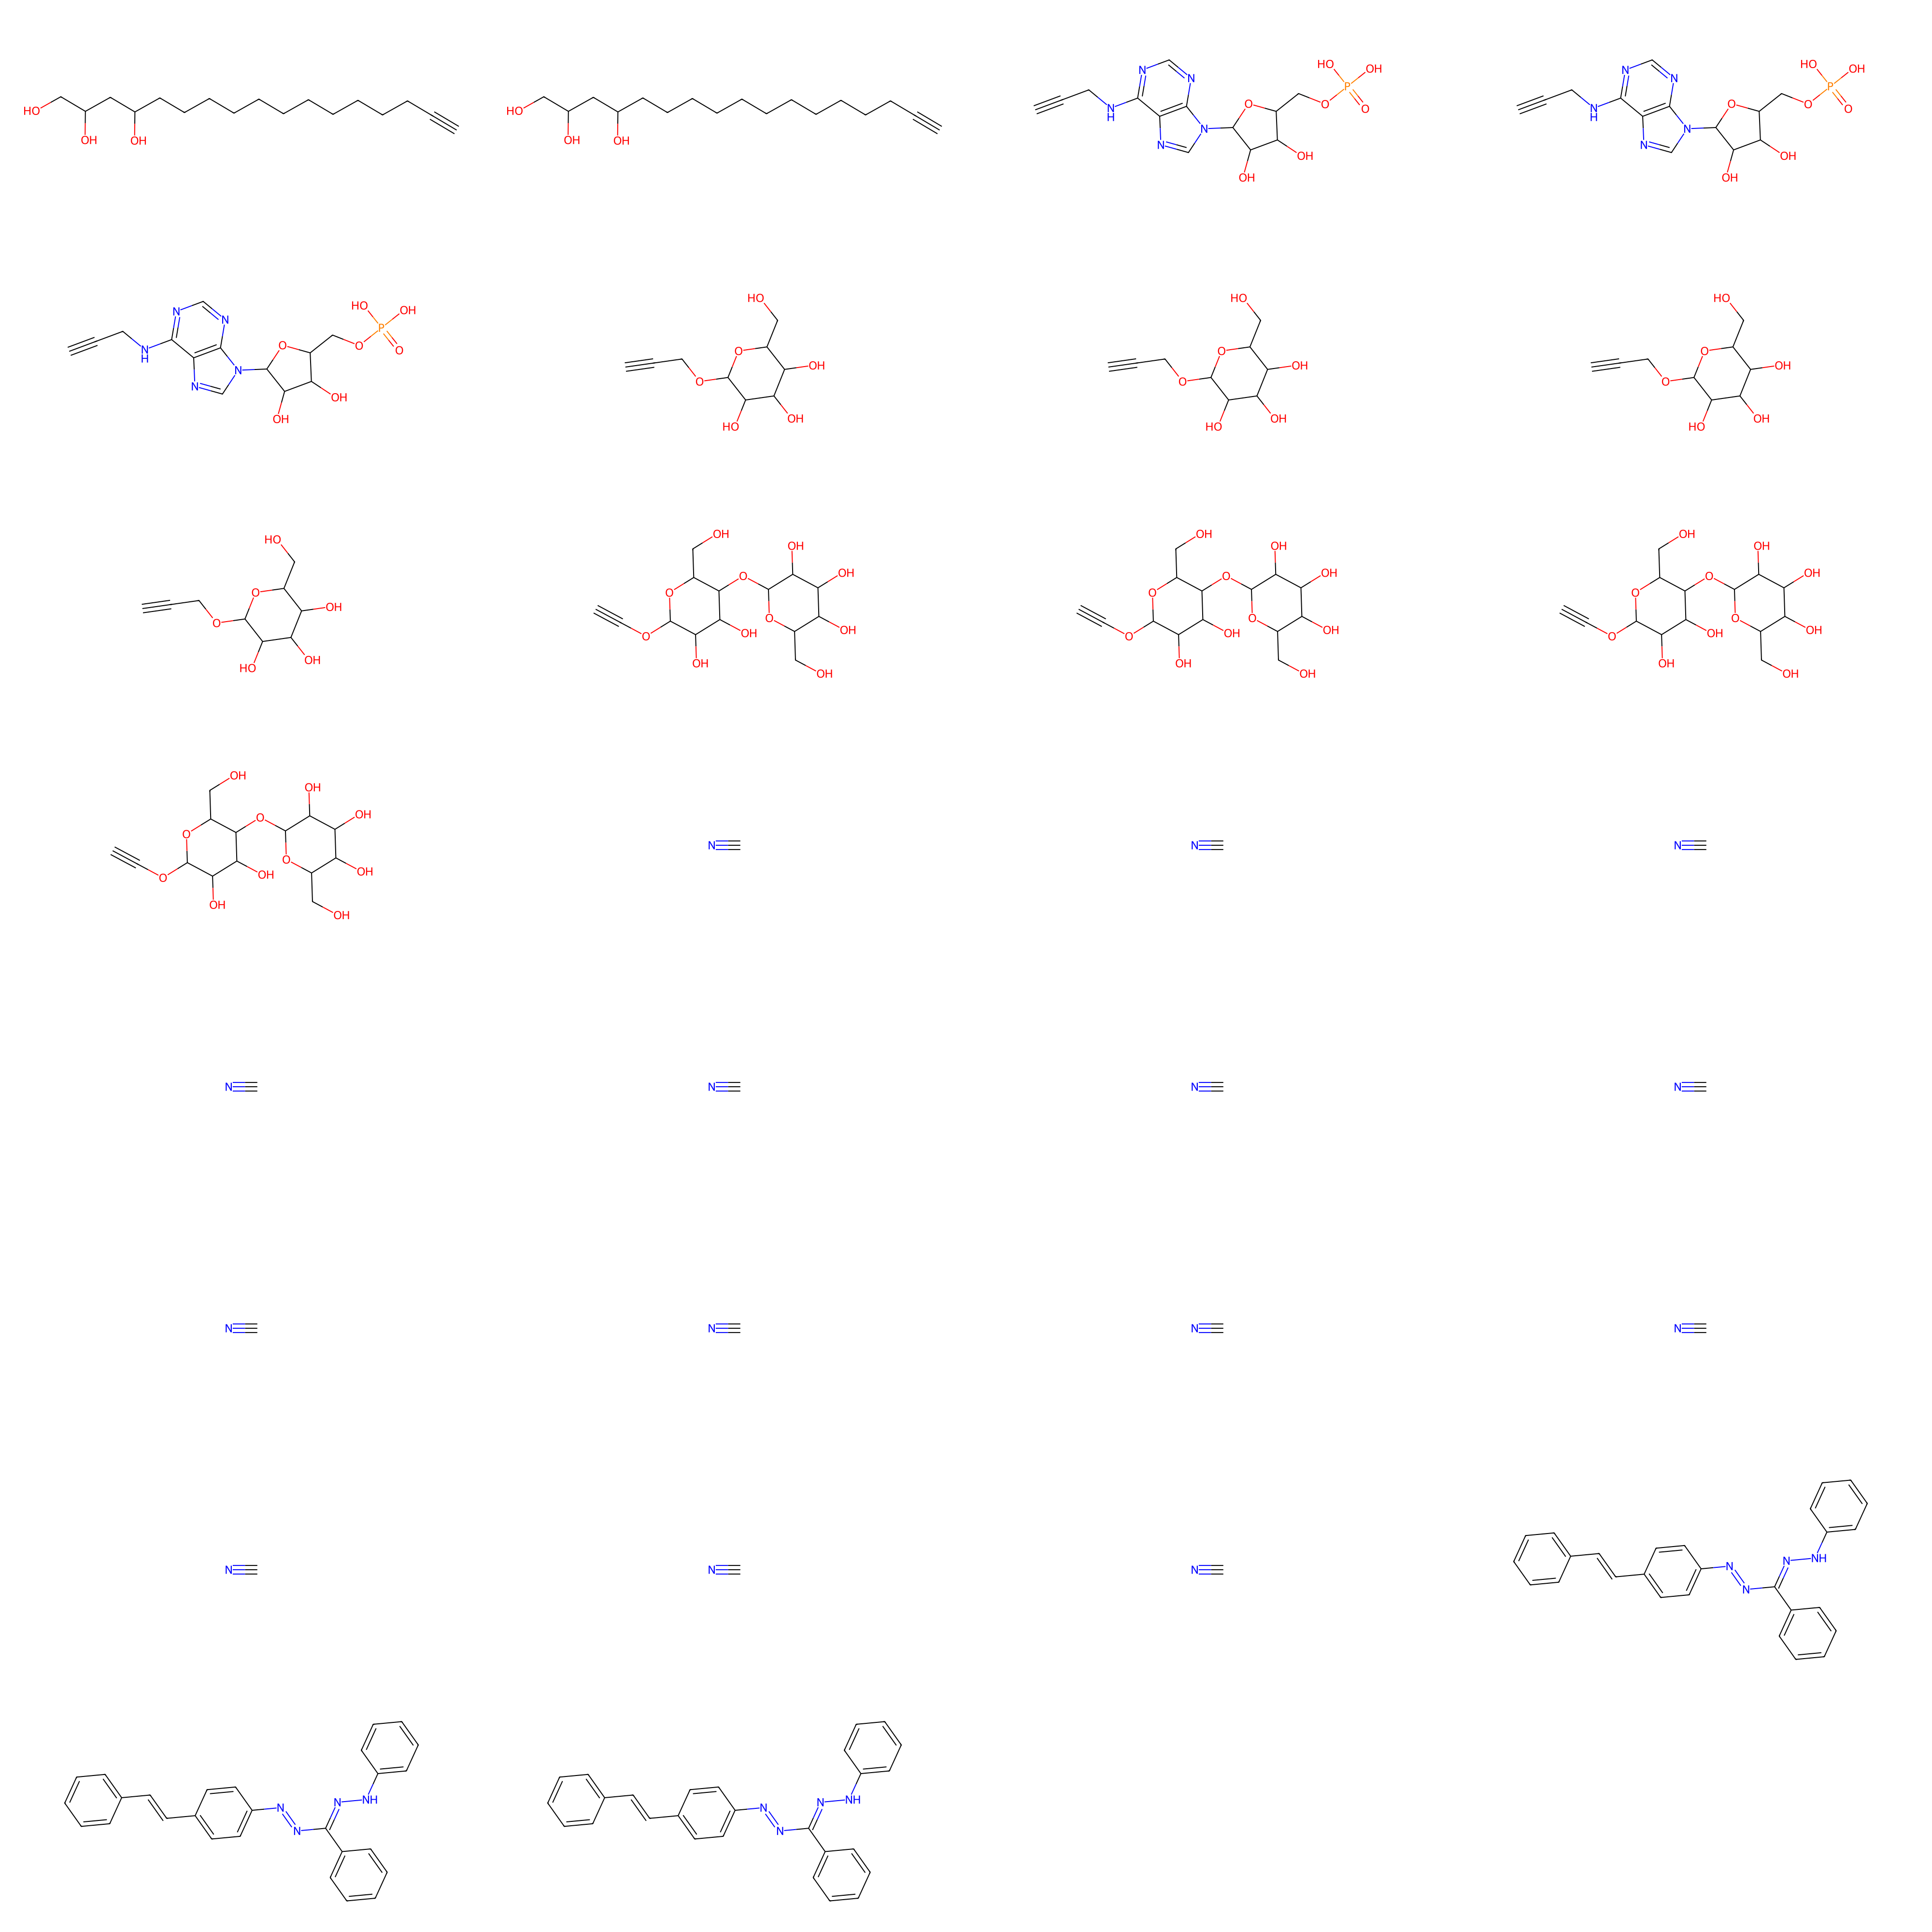

In [28]:
# Identify duplicate entries of standardised smiles AND taste, since multi-taste instances have multiple entries with shared stand. smiles but differnt taste
duplicates = df[df.duplicated(subset=['Standardized SMILES', 'Canonicalized Taste'], keep=False)]

# Visualize duplicates
duplicates_sorted = duplicates.sort_values(by='Standardized SMILES')

PandasTools.FrameToGridImage(duplicates_sorted, column='mol', legendsCol=None, molsPerRow=4, subImgSize=(1000, 500), maxMols=30)

In [33]:
# Drop duplicate rows
df = df.drop_duplicates(subset=['Standardized SMILES', 'Canonicalized Taste'])

number_molecules.append(len(df))

# Remove molecules heavier than 2000 Da
df = df[df['Standardized SMILES'].apply(
    lambda smiles: rdMolDescriptors.CalcExactMolWt(Chem.MolFromSmiles(smiles)) <= 2000 if Chem.MolFromSmiles(smiles) else False)]

[11:49:09] WARNING: not removing hydrogen atom without neighbors
[11:49:09] WARNING: not removing hydrogen atom without neighbors
[11:49:10] WARNING: not removing hydrogen atom without neighbors
[11:49:10] WARNING: not removing hydrogen atom without neighbors
[11:49:11] WARNING: not removing hydrogen atom without neighbors
[11:49:11] WARNING: not removing hydrogen atom without neighbors
[11:49:11] WARNING: not removing hydrogen atom without neighbors
[11:49:11] WARNING: not removing hydrogen atom without neighbors
[11:49:11] WARNING: not removing hydrogen atom without neighbors
[11:49:11] WARNING: not removing hydrogen atom without neighbors


In [34]:
df['Canonicalized Taste'].value_counts()

Canonicalized Taste
sweet        9542
undefined    2150
bitter       1676
sour         1605
umami          58
Name: count, dtype: int64

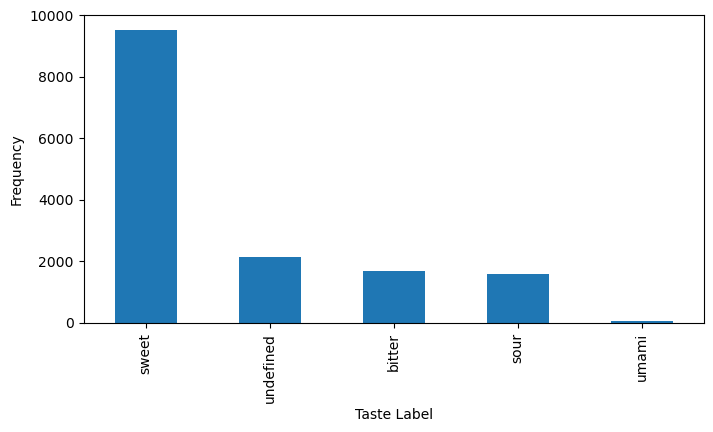

In [35]:
import matplotlib.pyplot as plt

# Plot the histogram
plt.figure(figsize=(8, 4))
# plt.hist(df['Canonicalized Taste'], bins=6, color='green', edgecolor='black')
df['Canonicalized Taste'].value_counts().plot(kind="bar")
# plt.title('Taste Distribution')

plt.xlabel('Taste Label')
plt.ylabel('Frequency')
# plt.yscale('log')
plt.show()

In [39]:
selected_columns = ['Canonicalized SMILES', 'Standardized SMILES', 'Canonicalized Taste', 'Original Labels', 'Source']

df_output = df[selected_columns]
df_output.to_csv('fart_curated.csv', index=False, header=True)


In [36]:
df['Canonicalized Taste'].describe()

count     15031
unique        5
top       sweet
freq       9542
Name: Canonicalized Taste, dtype: object

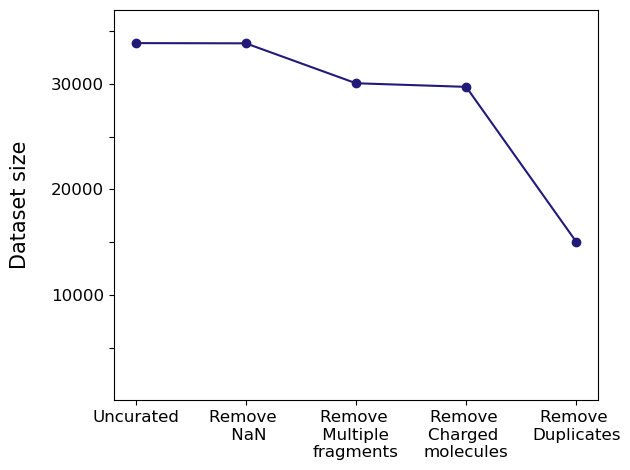

In [68]:
labels = ["Uncurated", "Remove \n NaN", "Remove \n Multiple \nfragments", "Remove \nCharged \nmolecules", "Remove \nDuplicates"]#, "Outlier removal"]

plt.plot(number_molecules, marker='o', linestyle='-', color='#211A79')  # 'o' marker style, '-' line style
plt.ylabel('Dataset size', fontsize=15, labelpad=15)
# plt.title('Dataset size throughout curation')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)

plt.ylim((0, 37000))
plt.yticks([5000,10000, 15000, 20000,25000, 30000,35000], ['','10000','','20000','','30000',''], fontsize=12)
plt.xticks(fontsize=12)

plt.tight_layout()
plt.show()

# Data Exploration

In [70]:
sour = df[df['Canonicalized Taste'] == 'sour']
bitter = df[df['Canonicalized Taste'] == 'bitter']
sweet = df[df['Canonicalized Taste'] == 'sweet']
umami = df[df['Canonicalized Taste'] == 'umami']
undefined = df[df['Canonicalized Taste'] == 'undefined']

In [71]:
print('sour: ', len(sour))
print('bitter: ', len(bitter))
print('sweet: ', len(sweet))
print('umami: ', len(umami))
print('undefined: ', len(undefined))
print('total: ', len(df))

sour:  1605
bitter:  1676
sweet:  9543
umami:  58
undefined:  2150
total:  15032


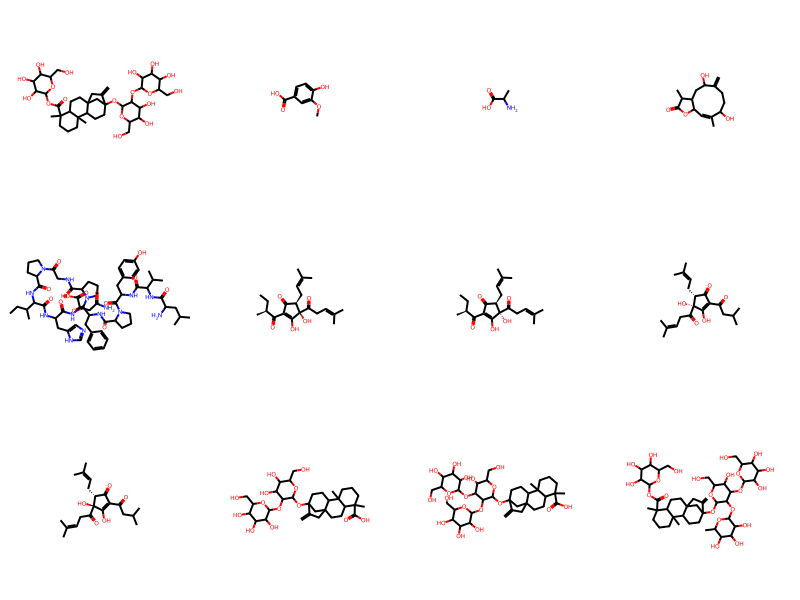

In [85]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Function to display multiple molecules
def display_molecules(mols, legends=None, mols_per_row=4, sub_img_size=(200, 200), max_mols=12):
    if legends is None:
        legends = [''] * len(mols)
    mols = [mol for mol in mols if mol is not None][:max_mols]
    legends = legends[:max_mols]
    img = Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=sub_img_size, legends=legends)
    return img


# Display the molecules in the DataFrame
img = display_molecules(bitter['mol'][1000:1600])
display(img)